In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.optimizers import Adam 

from utils.processing.v02.dataset import TradingDataset

2025-03-13 02:55:40.937436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEQUENCE_LENGTH = 9
PREDICTION_LENGTH = 5
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [3]:
df = pd.read_csv('../../market_data.csv')
df.tail()

,DATETIME,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LIGNE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
9995,2025-03-12 22:00:00,1.08896,1.08930,1.08850,1.08869,1150,1.08989,45.39,-0.00010,0.00014,1.09009,1.09252,1.57205,0.00210
9996,2025-03-12 23:00:00,1.08835,1.08892,1.08835,1.08841,436,1.08969,44.43,-0.00020,0.00010,1.08997,1.09250,1.61803,0.00203
9997,2025-03-13 00:00:00,1.08874,1.08897,1.08866,1.08886,537,1.08958,46.38,-0.00025,0.00007,1.08990,1.09246,1.40390,0.00189
9998,2025-03-13 01:00:00,1.08894,1.08900,1.08832,1.08856,657,1.08944,45.24,-0.00030,0.00002,1.08984,1.09247,1.48654,0.00185
9999,2025-03-13 02:00:00,1.08858,1.08868,1.08826,1.08839,343,1.08930,44.57,-0.00036,-0.00006,1.08977,1.09247,1.50826,0.00176


In [4]:
ts = df.copy()
ts['DATETIME'] = pd.to_datetime(ts['DATETIME'])
ts = ts.set_index('DATETIME')
ts.sort_index(inplace=True)
ts = ts.loc['2024-05-01 00:00:00':]
ts = ts[:-20]
print(ts.shape)
ts.tail()

(5346, 13)


,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LIGNE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
DATETIME,,,,,,,,,,,,,
2025-03-12 02:00:00,1.09140,1.09157,1.09054,1.09090,1760,1.09110,56.34,0.00149,0.00199,1.09083,1.09547,0.98576,0.00149
2025-03-12 03:00:00,1.09092,1.09154,1.09058,1.09066,2155,1.09104,54.97,0.00133,0.00189,1.09118,1.09453,1.15369,0.00139
2025-03-12 04:00:00,1.09065,1.09116,1.09034,1.09039,1702,1.09095,53.39,0.00117,0.00177,1.09141,1.09366,1.45479,0.00132
2025-03-12 05:00:00,1.09038,1.09050,1.08960,1.08969,1262,1.09078,49.44,0.00097,0.00162,1.09144,1.09357,1.82493,0.00124
2025-03-12 06:00:00,1.08971,1.09028,1.08957,1.08989,1356,1.09066,50.57,0.00082,0.00146,1.09135,1.09358,1.65723,0.00111


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [5]:
dataset = TradingDataset(ts, shift_size=SHIFT_SIZE, sequence_length=SEQUENCE_LENGTH)
dataset.prepare_data()

# Préparation des données de modélisation

In [6]:
X, y = dataset.feature_sequence, dataset.target_sequence

In [7]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [22]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    LSTM(512),
    Dense(8, activation='relu'),
    Dense(3, activation='linear')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.00001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 512)            │     1,132,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136,675 (4.34 MB)

 Trainable params: 1,136,675 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [23]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.2960 - val_loss: 0.0437
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.1996 - val_loss: 0.0265
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0560 - val_loss: 0.0033
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 8.2705e-04 - val_loss: 0.0017
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 6.8203e-04 - val_loss: 0.0013
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 5.3423e-04 - val_loss: 0.0011
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 4.9322e-04 - val_loss: 9.3075e-04
Epoch 9/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 4.3097e-04 - val_loss: 8.6664e-04
Epoch 10/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 3.9296e-04 - val_loss: 8.2047e-04
Epoch 11/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 3.8817e-04 

## Evaluation du modèle

### Courbe d'apprentissage

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


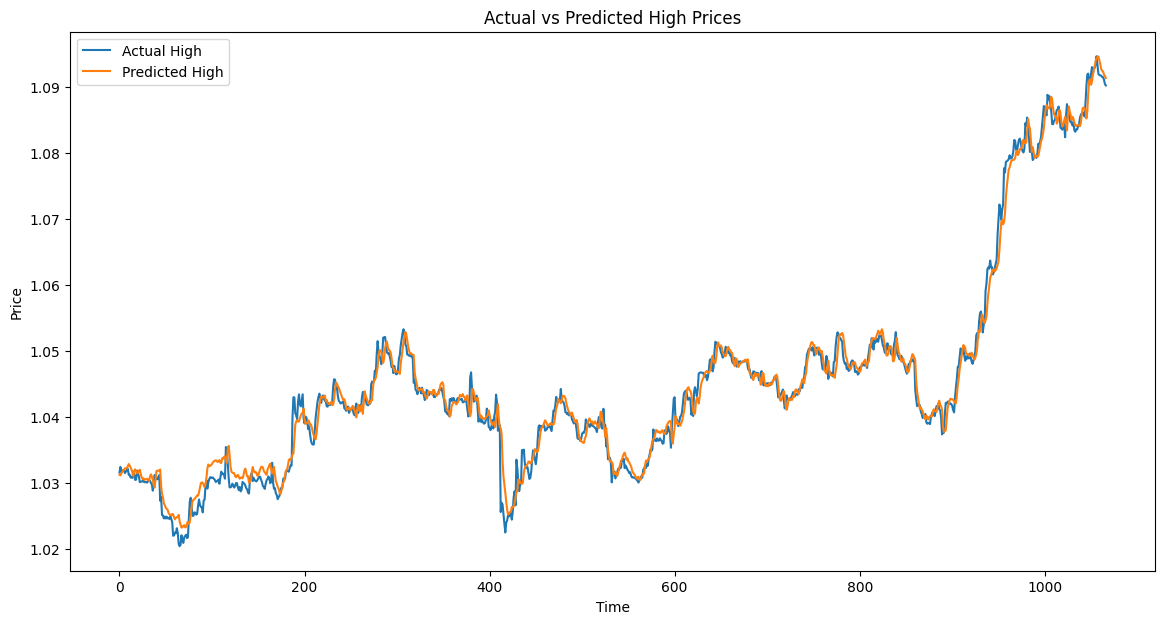

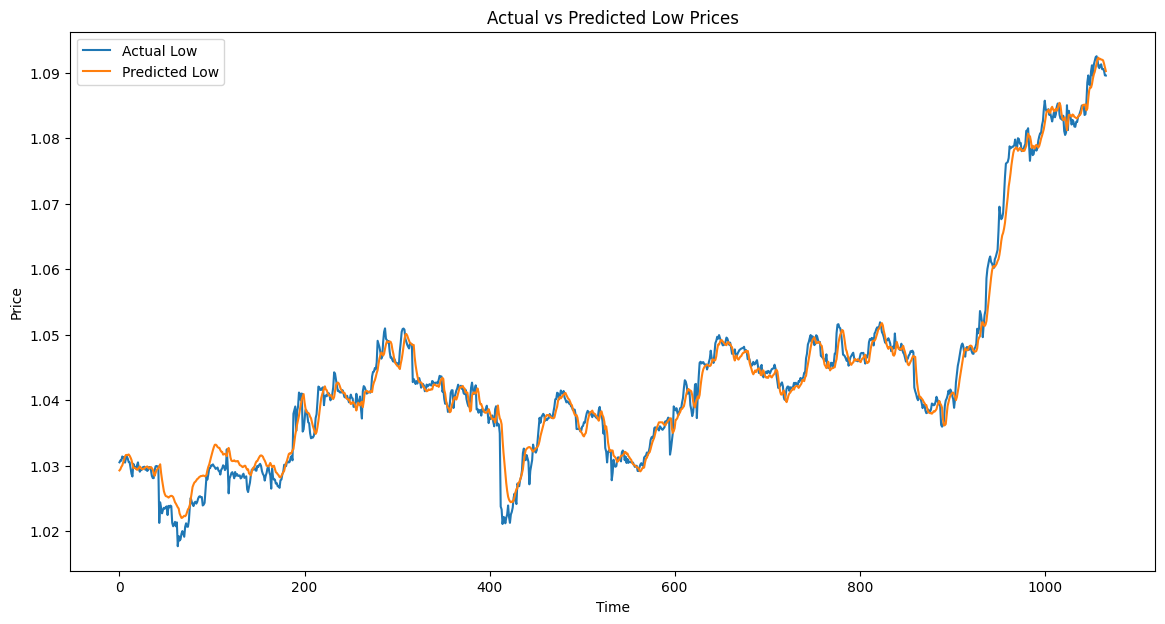

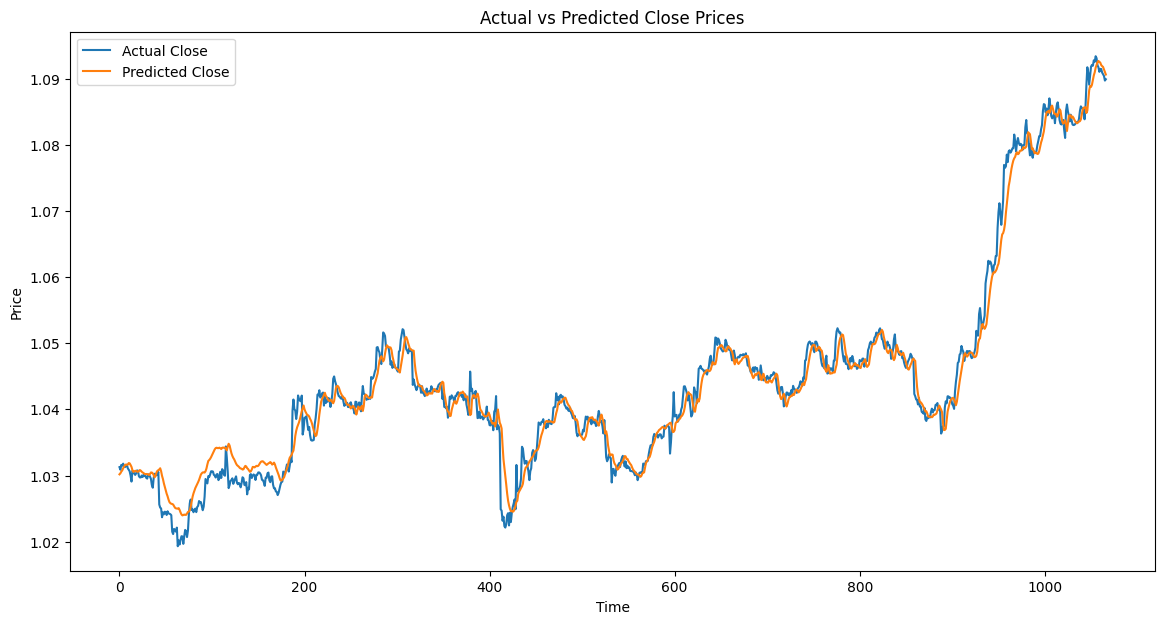

In [24]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = dataset.target_scaler.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = dataset.target_scaler.inverse_transform(y_test)

# plot actual vs prediction for each feature
features = ['High', 'Low', 'Close']
for i, feature in enumerate(features):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_actual[:, i], label=f'Actual {feature}')
    plt.plot(predictions[:, i], label=f'Predicted {feature}')
    plt.title(f'Actual vs Predicted {feature} Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


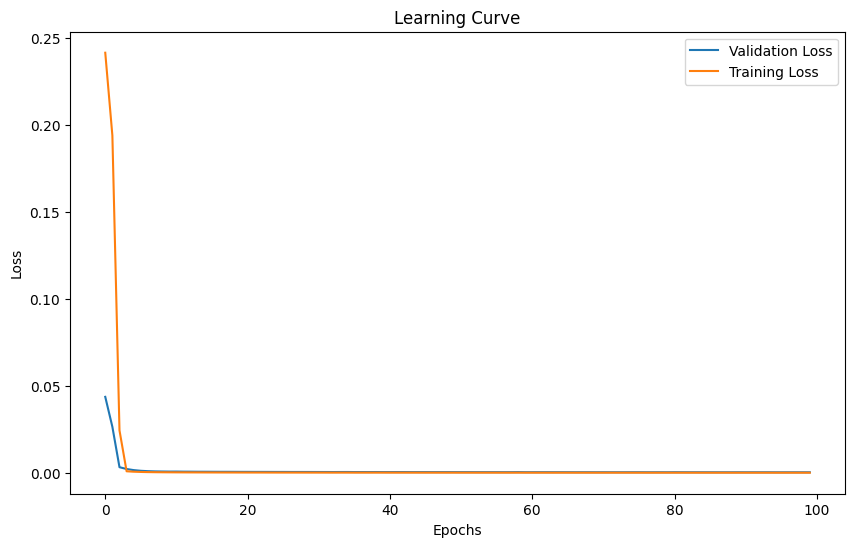

In [25]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [26]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 4.299192107432681e-06
Mean Absolute Error: 0.0014524496015210838
Root Mean Squared Error: 0.002073449325986213
RSquared :  98.29%


## Sauvegarde du model

In [ ]:
# history.model.save('../../models/test/best_model_EURUSD_candle.keras')
# print('Model saved!!')

Model saved!!


In [ ]:
# ts.to_csv('../../notebooks/inference/datasets/eur_usd_2024_03_2025.csv', index=True)